###NumtaDB Bangla handwritten Digits
Bengali Handwritten Digits recognization can be solved using many techniques.  I will use logistic regression for solving this problem
 
the main motive is to make the model recognize the hand written digit accurately.,changing the hyperparameter to see for which combination the accuracy is better.


**Numta DB** is a database.This database contains handwritten digits (0 through 9) in bengali, and can provide a baseline for testing image processing systems.


<div align="center">
<img src="https://drive.google.com/uc?id=1k5iKYOTrJmuSRPbWazZyBboaUPWabcmR" width="400">
</div>




**Importing all necessary library**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os
from os import path
from torchvision import  models
import shutil
import matplotlib.pyplot as plt 

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimom","key":"6658d2c401a0700e06b404d8140ba08f"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


**importing numtaDB dataset from kaggle**

In [ ]:
!kaggle datasets download -d BengaliAI/numta -p /content/gdrive/My\ Drive/Softcom

100% 1.91G/1.91G [00:17<00:00, 34.1MB/s]
100% 1.91G/1.91G [00:17<00:00, 115MB/s] 


**unzipping numta.zip dataset**

In [ ]:
from zipfile import ZipFile
file_name = "/content/gdrive/My Drive/Softcom/numta.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
from google.colab import drive #mounted all file and folder from google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**changing the directory**

In [ ]:
root_path = '/content/gdrive/My Drive/Softcom/'
Root = '/content/'
os.listdir(Root1)

['debugger_yzyhwhgxp',
 'dap_multiplexer.INFO',
 'initgoogle_syslog_dir.0',
 'dap_multiplexer.a354efee0f42.root.log.INFO.20210220-132604.49']

**Function for reading csv file**

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(Root+csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('training-a.csv')
b_csv = showRawTrainingSamples('training-b.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
e_csv = showRawTrainingSamples('training-e.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-b.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
training-e.csv
Index(['filename', 'original filename', 'districtid', 'institutionid',
       'gender', 'age', 'datestamp', 'scanid', 'digit',
       'database name original', 'database name'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)

**Merging all csv file**

In [ ]:
total_csv = [a_csv,c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

54908


In [ ]:
TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)


**All images in one folder function**

In [ ]:
def processImages(folder_name):
  src = Root + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  

In [ ]:
processImages('training-a')
print('A Done')
#processImages('training-b')
#print('B Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')
#processImages('training-e')
#print('E Done')


A Done
C Done
D Done


### Hyperparameter initialazation
Hyper parameter is predefined which is not changed during run time.But it is an important factor. we must be careful about choosing the hyperparameter value.
Here batch size,number of iteration,input dimension,output dimension,learning rate are Hyperparameters.Even choosing the optimizer is also a hyperparameter.we chose loss Entropy instead of MSE here for better output

In [ ]:
batch_size = 80
num_iters = 2000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Function for preparing Dataset**

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

**Resizing and normalizing  the trained and test images**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


**Showing Image**

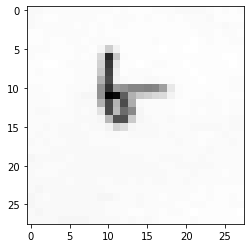

In [ ]:

show_img = train_data[250][0].numpy().reshape(28,28)
plt.imshow(show_img, cmap='gray')

In [ ]:
print(train_data[2052][0].numpy().shape)

(1, 28, 28)


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 80
  - Number of examples in **1** iteration

- **iterations:** 2000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 2000 \div \frac{54908}{80} = 2$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:618
Test dataloader:69


###Logistic Regression
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression[1] (or logit regression) is estimating the parameters of a logistic model (a form of binary regression). Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1". 

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

### Construct loss and optimizer (select from PyTorch API)

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax **([Logistic or Sigmoid]/softmax function)**
2. Computes Cross Entropy Loss

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training: forward, loss, backward, step

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 15.98112964630127. Accuracy: 11.092896174863387
Iteration: 1000. Loss: 20.191394805908203. Accuracy: 10.382513661202186


**Setting 2**

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 3000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{54908}{100} = 5$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 25.246177673339844. Accuracy: 10.109289617486338
Iteration: 1000. Loss: 27.081148147583008. Accuracy: 9.508196721311476
Iteration: 1500. Loss: 21.35369873046875. Accuracy: 13.151183970856103
Iteration: 2000. Loss: 27.233478546142578. Accuracy: 10.382513661202186


**Setting3**

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 3000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{54908}{100} = 5$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2938430309295654. Accuracy: 11.183970856102004
Iteration: 1000. Loss: 2.2912189960479736. Accuracy: 10.273224043715848
Iteration: 1500. Loss: 2.292511224746704. Accuracy: 12.568306010928962
Iteration: 2000. Loss: 2.2945985794067383. Accuracy: 11.03825136612022


**Setting 4**

In [ ]:
batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 6000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 6000 \div \frac{54908}{100} = 10$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2861320972442627. Accuracy: 10.036429872495447
Iteration: 1000. Loss: 2.306555986404419. Accuracy: 11.001821493624773
Iteration: 1500. Loss: 2.3008623123168945. Accuracy: 11.766848816029144
Iteration: 2000. Loss: 2.2973828315734863. Accuracy: 15.22768670309654
Iteration: 2500. Loss: 2.288130760192871. Accuracy: 15.482695810564662
Iteration: 3000. Loss: 2.284956932067871. Accuracy: 14.681238615664846
Iteration: 3500. Loss: 2.274024724960327. Accuracy: 17.959927140255008
Iteration: 4000. Loss: 2.28307843208313. Accuracy: 18.59744990892532
Iteration: 4500. Loss: 2.2701964378356934. Accuracy: 18.233151183970858


**Setting 5**

In [ ]:
batch_size = 32
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 32
  - Number of examples in **1** iteration

- **iterations:** 5000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 5000 \div \frac{54908}{32} = 2$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:1545
Test dataloader:172


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2974557876586914. Accuracy: 10.29143897996357
Iteration: 1000. Loss: 2.2858009338378906. Accuracy: 10.52823315118397
Iteration: 1500. Loss: 2.345881938934326. Accuracy: 10.145719489981785
Iteration: 2000. Loss: 2.3118555545806885. Accuracy: 11.675774134790528
Iteration: 2500. Loss: 2.2939467430114746. Accuracy: 10.947176684881603
Iteration: 3000. Loss: 2.2994260787963867. Accuracy: 10.510018214936247


**Setting 6**


In [ ]:
batch_size = 200
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 200
  - Number of examples in **1** iteration

- **iterations:** 5000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 5000 \div \frac{54908}{200} = 18$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3067924976348877. Accuracy: 8.797814207650273
Iteration: 1000. Loss: 2.3036117553710938. Accuracy: 10.29143897996357
Iteration: 1500. Loss: 2.295410394668579. Accuracy: 10.856102003642988
Iteration: 2000. Loss: 2.2986769676208496. Accuracy: 14.82695810564663
Iteration: 2500. Loss: 2.2884795665740967. Accuracy: 12.750455373406194
Iteration: 3000. Loss: 2.287173271179199. Accuracy: 18.37887067395264
Iteration: 3500. Loss: 2.29063081741333. Accuracy: 20.036429872495447
Iteration: 4000. Loss: 2.281463384628296. Accuracy: 19.799635701275047


**Setting 7**

In [ ]:
batch_size = 200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 200
  - Number of examples in **1** iteration

- **iterations:** 10000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 10000 \div \frac{54908}{200} = 36$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2988016605377197. Accuracy: 10.728597449908925
Iteration: 1000. Loss: 2.301626443862915. Accuracy: 9.41712204007286
Iteration: 1500. Loss: 2.297241449356079. Accuracy: 10.491803278688524
Iteration: 2000. Loss: 2.291654109954834. Accuracy: 9.508196721311476
Iteration: 2500. Loss: 2.294448137283325. Accuracy: 10.163934426229508
Iteration: 3000. Loss: 2.291027545928955. Accuracy: 12.021857923497267
Iteration: 3500. Loss: 2.2889580726623535. Accuracy: 14.681238615664846
Iteration: 4000. Loss: 2.285304069519043. Accuracy: 16.994535519125684
Iteration: 4500. Loss: 2.2855584621429443. Accuracy: 16.97632058287796
Iteration: 5000. Loss: 2.2752764225006104. Accuracy: 25.00910746812386
Iteration: 5500. Loss: 2.2701685428619385. Accuracy: 26.994535519125684
Iteration: 6000. Loss: 2.276379346847534. Accuracy: 26.939890710382514
Iteration: 6500. Loss: 2.2722508907318115. Accuracy: 28.306010928961747
Iteration: 7000. Loss: 2.259967565536499. Accuracy: 28.561020036429873
Iterat


###Result
|Setting| Batch Size       | No. of iteration     | Learning Rate     |
| :------------- | :----------: | -----------: |:------------- |
|           |
|1|  80 | 2000   | .1    |
|2| 100   | 3000 | .1|
|3| 100|3000 |.001 |
|4| 100|6000 |.001 |
|5|32|5000|.001|
|6|200|5000|.001|
|7|200|10000|.001||

In first setting batch size is 80, no. of iteration is 2000 and learning rate is .1 the accuracy is 10-11% .In setting 2 batch size was updated  others were remained same. but there was no increasing of accuracy.in setting 3 i kept batch size and  no. of iteration same and learning rate was changed from .1 to .001  still there is no improvement of the accuracy.but in setting 4 when i changed the no. of iteration from 3000 to 6000 and others were kept same then improvement in the accuracy was shown.in setting 6 and 7 batch size was decreased very less and after that setting batch size was increased very high. but there is no difference was visible in term of accuracy.
At last in last setting  no. of iteration was 10000 and accuracy was the best among all of the settings.
So,in my model higher no. of iteration is increasing the accuracy . 

